# Analyzing impact of AB test in revenue
We want to detect if there is any significant difference in revenue between both variants: control and variant.

## Import libraries

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, mannwhitneyu, chisquare, shapiro, levene, bartlett, median_test
from statsmodels.stats.power import TTestIndPower

## Load Data

In [3]:
dataframe = pd.read_csv('./assets/ab_test_results.csv')
dataframe.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


## Data Understanding

#### Basic exploratory review

In [4]:
print(" ROWS & COLUMNS ".center(70,'-'))
print("Number of rows: {}".format(dataframe.shape[0]))
print("Column Names: "+', '.join('{}'.format(col) for col in dataframe.columns.tolist()))
print(" COLUMN TYPES ".center(70,'-'))
print(dataframe.dtypes)
print(" NULLS ".center(70,'-'))
print(dataframe.isnull().sum())
print(" DUPLICATES ".center(70,'-'))
print(dataframe.duplicated().sum())

--------------------------- ROWS & COLUMNS ---------------------------
Number of rows: 10000
Column Names: USER_ID, VARIANT_NAME, REVENUE
---------------------------- COLUMN TYPES ----------------------------
USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object
------------------------------- NULLS --------------------------------
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64
----------------------------- DUPLICATES -----------------------------
2067


#### Distritbution and values

In [5]:
print(" REVENUE DISTRIBUTION ".center(70,'-'))
print(dataframe["REVENUE"].describe(percentiles=[0.01, 0.1, 0.25, 0.50, 0.75, 0.90, 0.99]).T)
print(" VARIANT NAME ".center(70,'-'))
print(dataframe["VARIANT_NAME"].describe())
print(" USER_ID ".center(70,'-'))
print(dataframe["USER_ID"].astype("string").describe())

------------------------ REVENUE DISTRIBUTION ------------------------
count    10000.000000
mean         0.099447
std          2.318529
min          0.000000
1%           0.000000
10%          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
99%          1.660900
max        196.010000
Name: REVENUE, dtype: float64
---------------------------- VARIANT NAME ----------------------------
count       10000
unique          2
top       variant
freq         5016
Name: VARIANT_NAME, dtype: object
------------------------------ USER_ID -------------------------------
count     10000
unique     6324
top        5652
freq          6
Name: USER_ID, dtype: object


#### Observations
I will keep the duplicates since a user might have made purchases in two different opportunities.  
I will cast User ID as string since it is a unique identifier, not a 'number'

## SRM Analysis

#### Were users exposed to both variants? If yes, how many?

In [6]:
variants_per_user_df = dataframe.groupby("USER_ID")["VARIANT_NAME"].nunique()
variants_per_user_df[variants_per_user_df>1].count()

1541

#### Remove user who were exposed to both variants

In [7]:
both_variants_users = variants_per_user_df[variants_per_user_df>1].index.tolist()
clean_df = dataframe[~dataframe["USER_ID"].isin(both_variants_users)].reset_index()

## Quality Check
print(dataframe["USER_ID"].nunique() == len(both_variants_users) + clean_df["USER_ID"].nunique())

True


#### Observation
Having ~25% of users exposed to both variants is a severe bug. We would need to analyze if this error in the assignment is random or not, making the experiment invalid.

#### New revenue distribution

In [8]:
print(" REVENUE DISTRIBUTION ".center(70,'-'))
print(clean_df["REVENUE"].describe(percentiles=[0.01, 0.1, 0.25, 0.50, 0.75, 0.90, 0.99]).T)

------------------------ REVENUE DISTRIBUTION ------------------------
count    6070.000000
mean        0.107064
std         2.673501
min         0.000000
1%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%         0.000000
99%         2.160000
max       196.010000
Name: REVENUE, dtype: float64


#### Chi-square test to compare samples of both variants

In [9]:
control_users = clean_df[clean_df["VARIANT_NAME"] == 'control']["USER_ID"].nunique()
variant_users = clean_df[clean_df["VARIANT_NAME"] == 'variant']["USER_ID"].nunique()
total_users = control_users + variant_users
stat, pvalue = chisquare([control_users, variant_users], f_exp=[total_users/2, total_users/2])
print("Samples difference: {}%".format(round(100*(variant_users - control_users)/control_users,2)))
if pvalue < 0.01: print("Warning, SRM might be present")
else: print("Probably no SRM")

Samples difference: 0.13%
Probably no SRM


## Outliers

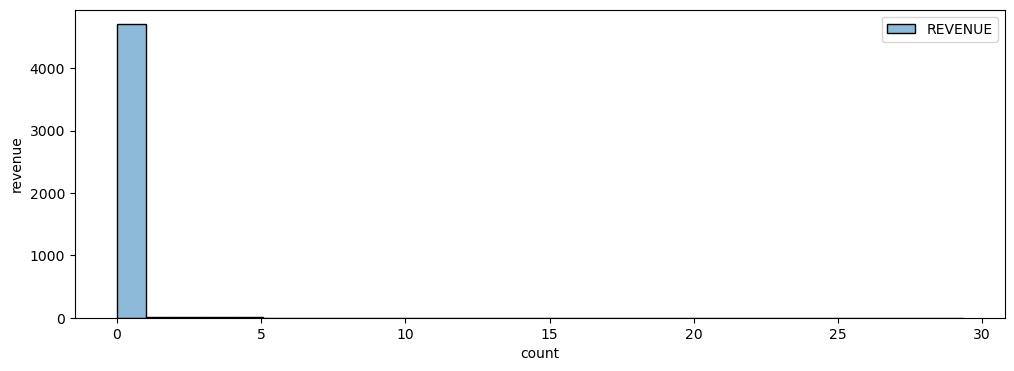

In [35]:
#Sturge’s Rule for number of bins
n_bins = 1 + 3.322*np.log(clean_df.groupby(["VARIANT_NAME","USER_ID"]).agg({"REVENUE":"sum"}).count())

f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.histplot(clean_df.groupby(["VARIANT_NAME","USER_ID"]).agg({"REVENUE":"sum"}), bins=int(round(n_bins)))

plt.xlabel('count')
plt.ylabel('revenue')
plt.show()

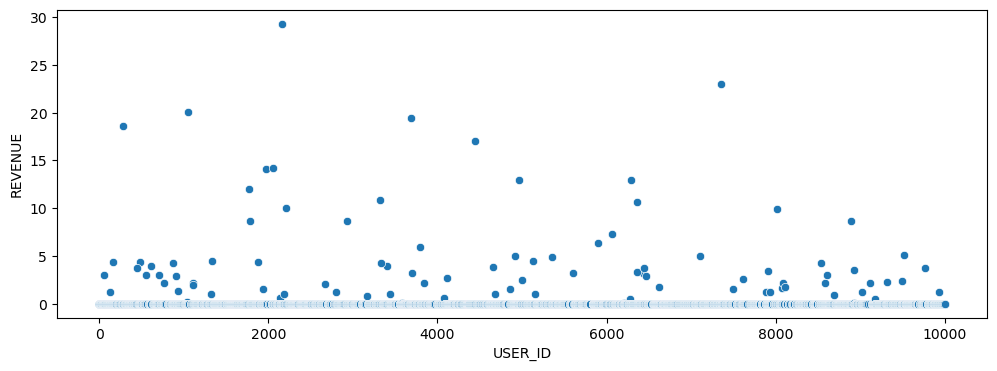

In [36]:
unique_revenues = clean_df.groupby(["VARIANT_NAME","USER_ID"]).agg({"REVENUE":"sum"})["REVENUE"].unique()

f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.scatterplot(clean_df.groupby(["VARIANT_NAME","USER_ID"]).agg({"REVENUE":"sum"})["REVENUE"].reset_index(), x="USER_ID", y="REVENUE")
plt.show()

#### I'll remove revenues above 20

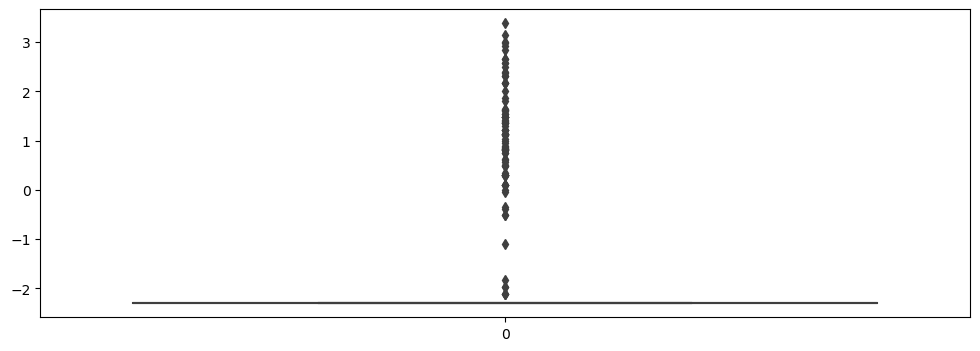

In [37]:
clean_df["LOG_REVENUE"] = np.log(clean_df["REVENUE"] + 0.1)

f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.boxplot(clean_df["LOG_REVENUE"])
plt.show()

In [13]:
clean_df = clean_df[clean_df["REVENUE"] < 20]

## Aggregate revenue vector per randomization unit

In [14]:
revenue_per_user = clean_df.groupby(["VARIANT_NAME","USER_ID"]).agg({"REVENUE":"sum"}).reset_index()
revenue_per_control_user = revenue_per_user[revenue_per_user["VARIANT_NAME"] == 'control']["REVENUE"]
revenue_per_variant_user = revenue_per_user[revenue_per_user["VARIANT_NAME"] == 'variant']["REVENUE"]

## Power Analysis

In [94]:
power_analysis = TTestIndPower()

sample_size_1 = power_analysis.solve_power(effect_size = 0.01, alpha = 0.05, power = 0.8, alternative = 'two-sided')
sample_size_10 = power_analysis.solve_power(effect_size = 0.1, alpha = 0.05, power = 0.8, alternative = 'two-sided')

print("The sample size needed for each group to detect an effect size of 1% is {}".format(round(sample_size_1)))
print("The sample size needed for each group to detect an effect size of 10% is {}".format(round(sample_size_10)))

The sample size needed for each group to detect an effect size of 1% is 156978
The sample size needed for each group to detect an effect size of 10% is 1571


In [16]:
# Another option
# Van Belle (2002) formula
revenue_per_control_user = revenue_per_user[revenue_per_user["VARIANT_NAME"] == 'control']["REVENUE"]
count_control = int(revenue_per_control_user.count())
mean_control = float(revenue_per_control_user.mean())
std_control = float(revenue_per_control_user.std())
mde = 0.01

print('Users per variant to detect a {}% effect: {}'.format(100*mde, round(16*(std_control)**2/(mde*mean_control)**2)))
print('Total users to detect a {}% effect: {}'.format(100*mde, round(2*16*(std_control)**2/(mde*mean_control)**2)))

Users per variant to detect a 1.0% effect: 16371605
Total users to detect a 1.0% effect: 32743211


In [17]:
# More conservative approach
# Wheeler formula (1974)
print('Users per variant to detect a {}% effect: {}'.format(100*mde, round((4*2*std_control/mde*mean_control)**2)))
print('Total users to detect a {}% effect: {}'.format(100*mde, round(2*(4*2*std_control/mde*mean_control)**2)))

Users per variant to detect a 1.0% effect: 11423
Total users to detect a 1.0% effect: 22846


## P Value

In [18]:
#Check for Normality
norm_control = shapiro(revenue_per_control_user)[1]
norm_variant = shapiro(revenue_per_variant_user)[1]

if (norm_control > 0.05) & (norm_variant > 0.05):
    
    #Check homogeneity: bartlett for non-normal distributions
    homogeneity = bartlett(revenue_per_control_user, revenue_per_variant_user)
    
    if homogeneity < 0.05:
        #Normal but different variances: Welch's t-test
        p_value = ttest_ind(revenue_per_control_user, revenue_per_variant_user, equal_var=False, alternative='two-sided')[1]
    else:
        #Normal but same variance
        p_value = ttest_ind(revenue_per_control_user, revenue_per_variant_user, equal_var=True, alternative='two-sided')[1]
else:
    # Non normal distribution
    p_value = mannwhitneyu(revenue_per_control_user, revenue_per_variant_user, alternative='two-sided')[1]

if p_value < 0.05: print("With a pvalue of {}, there is enough evidence to reject the null hypothesis. Control and variant means are different.".format(round(p_value, 2)))
else: print("With a pvalue of {}, there is not enough evidence to reject the null hypothesis. Can't tell if the control and variant means are different.".format(round(p_value, 2)))

With a pvalue of 0.25, there is not enough evidence to reject the null hypothesis. Can't tell if the control and variant means are different.


In [58]:
p_value_median = median_test(revenue_per_control_user, revenue_per_variant_user).pvalue
if p_value_median < 0.05: print("With a pvalue of {}, there is enough evidence to reject the null hypothesis. Control and variant medians are different.".format(round(p_value_median, 2)))
else: print("With a pvalue of {}, there is not enough evidence to reject the null hypothesis. Can't tell if the control and variant medians are different.".format(round(p_value_median, 2)))

With a pvalue of 0.3, there is not enough evidence to reject the null hypothesis. Can't tell if the control and variant medians are different.


In [91]:
df = revenue_per_user[["REVENUE", "VARIANT_NAME"]]
bootstrap_sample_size = len(df) 

mean_diffs = []
median_diffs = []
for i in range(100):
    bootstrap_sample = df.sample(n = bootstrap_sample_size, replace = True)
    mean_diff = bootstrap_sample[bootstrap_sample["VARIANT_NAME"] == 'variant'].mean(numeric_only=True) - bootstrap_sample[bootstrap_sample["VARIANT_NAME"] == 'control'].mean(numeric_only=True)
    median_diff = bootstrap_sample[bootstrap_sample["VARIANT_NAME"] == 'variant'].median(numeric_only=True) - bootstrap_sample[bootstrap_sample["VARIANT_NAME"] == 'control'].median(numeric_only=True)
    mean_diffs.append(mean_diff)
    median_diffs.append(median_diff)

# Mean confidence interval for alpha=0.05
lower_ci_mean = np.percentile(mean_diffs, 2.5)
upper_ci_mean = np.percentile(mean_diffs, 97.5)

# Median confidence interval for alpha=0.05
lower_ci_median = np.percentile(median_diffs, 2.5)
upper_ci_median = np.percentile(median_diffs, 97.5)

# Mean Point estimate
point_est_mean = df[df["VARIANT_NAME"] == 'variant'].mean(numeric_only=True) - df[df["VARIANT_NAME"] == 'control'].mean(numeric_only=True)
print('Point estimate of difference between means:', round(float(point_est_mean), 3))
print('95% confidence interval for the difference between means:', (round(lower_ci_mean,3), round(upper_ci_mean,3)),' this is base on 100 repetitions')

# Median Point estimate
point_est_median = df[df["VARIANT_NAME"] == 'variant'].median(numeric_only=True) - df[df["VARIANT_NAME"] == 'control'].median(numeric_only=True)
print('Point estimate of difference between means:', round(float(point_est_median), 3))
print('95% confidence interval for the difference between means:', (round(lower_ci_median,3), round(upper_ci_median,3)),' this is base on 100 repetitions')

columns = ['metric', 'lift', 'lower_ci', 'upper_ci']
output_df = pd.DataFrame(data=[['mean', float(point_est_mean), lower_ci_mean, upper_ci_mean], ['median', float(point_est_median), lower_ci_median, upper_ci_median]], columns=columns)
output_df

Point estimate of difference between means: -0.04
95% confidence interval for the difference between means: (-0.094, 0.015)  this is base on 100 repetitions
Point estimate of difference between means: 0.0
95% confidence interval for the difference between means: (0.0, 0.0)  this is base on 100 repetitions


,metric,lift,lower_ci,upper_ci
0,mean,-0.039987,-0.093793,0.014563
1,median,0.000000,0.000000,0.000000


<ErrorbarContainer object of 3 artists>

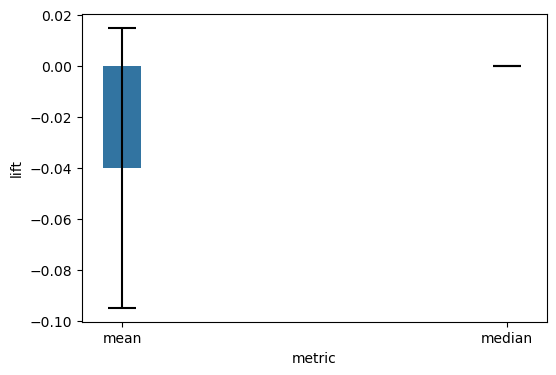

In [83]:
f = plt.figure(figsize=(6,4))

ax = f.add_subplot(111)
sns.barplot(data = output_df, x= "metric", y="lift", width=0.1)
plt.errorbar(x=output_df.index, y=output_df["lift"].values, yerr=(output_df["upper_ci"]-output_df["lower_ci"])/2, 
             fmt='none', ecolor='black', capsize=10, capthick=1.5)